In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, MaxPooling2D, Flatten, Input, Rescaling

2024-09-19 02:35:53.442730: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-19 02:35:53.442834: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-19 02:35:53.566269: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
data_dir = '/kaggle/input/satellite-image-classification/data'
batch_size = 32

train_set = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset='training',
    seed=24,
    image_size=(224, 224),
    batch_size=batch_size
)

test_set = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset='validation',
    seed=24,
    image_size=(224, 224),
    batch_size=batch_size
)

Found 5631 files belonging to 4 classes.
Using 4505 files for training.
Found 5631 files belonging to 4 classes.
Using 1126 files for validation.


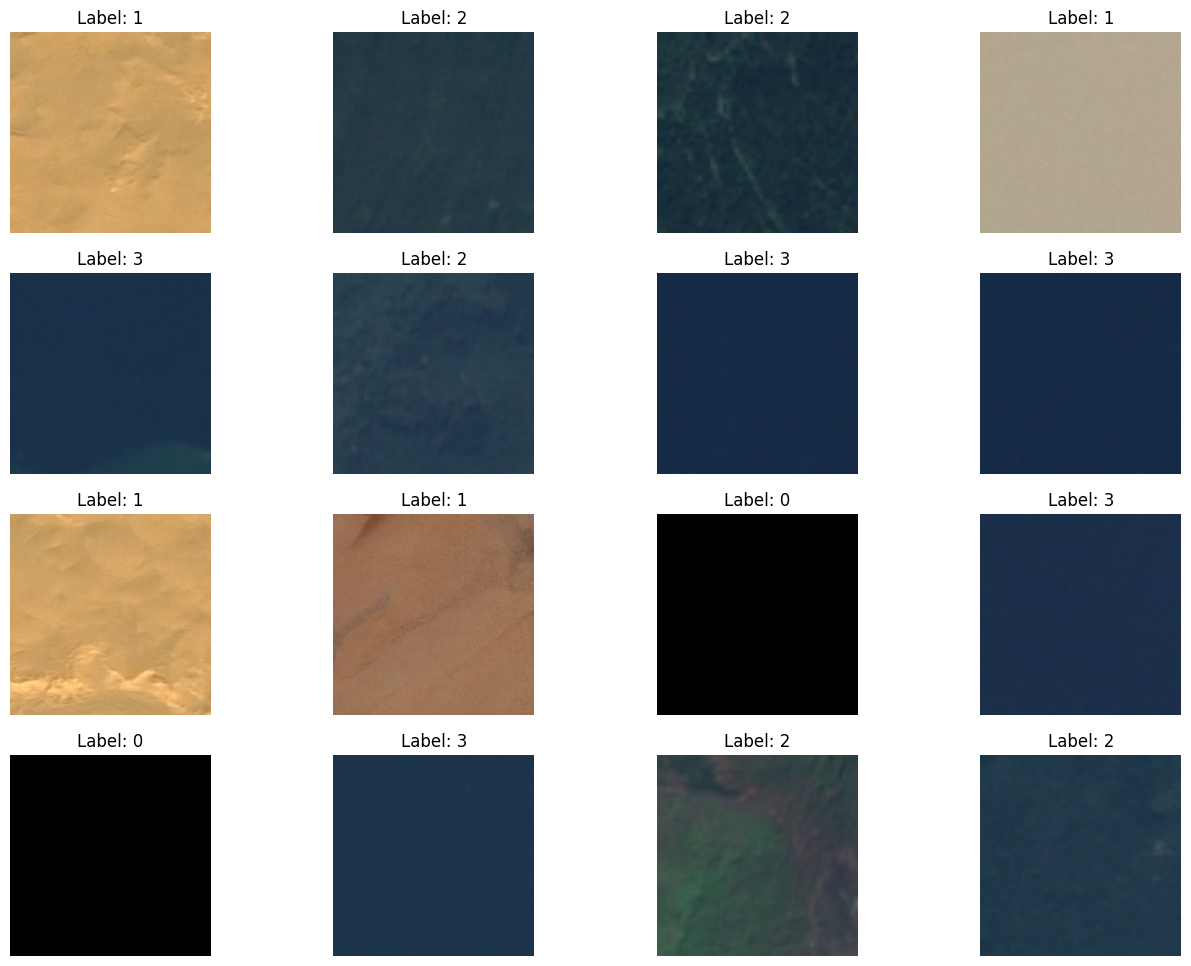

In [4]:
def plot_images(images, labels, num_img, cols):
    rows = num_img // cols
    
    plt.figure(figsize=(16, 12))
    for i in range(num_img):
        plt.subplot(rows, cols, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(f"Label: {labels[i].numpy()}")
        plt.axis('off')
    plt.show()    

for images, labels in train_set.take(1):
    plot_images(images, labels, 16, 4)

In [5]:
print(len(train_set.class_names))

4


In [6]:
# CNN model for image recognition

def cnn_model(input_shape, num_classes=None):
    if num_classes == None:
        raise ValueError("Specify number of classes")
        
    model = Sequential([
        Input(shape=input_shape),
        Rescaling(1./255),
        Conv2D(16,3, padding='same', activation='relu'),
        MaxPooling2D(),
        Conv2D(32,3, padding='same', activation='relu'),
        MaxPooling2D(),
        Conv2D(64,3, padding='same', activation='relu'),
        MaxPooling2D(),
        Conv2D(128,3, padding='same', activation='relu'),
        MaxPooling2D(),
        Flatten(),
        Dense(256, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    
    return model

In [7]:
input_shape = (224, 224, 3)
num_classes = len(train_set.class_names)

model = cnn_model(input_shape, num_classes)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,521,252 (24.88 MB)

 Trainable params: 6,521,252 (24.88 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
%%time

history = model.fit(
    train_set,
    validation_data=test_set,
    epochs=30
)

Epoch 1/30


2024-09-19 02:36:11.901750: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 223: 2.30379, expected 1.97036
2024-09-19 02:36:11.902102: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50176: 4.16142, expected 3.52349
2024-09-19 02:36:11.902134: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50177: 4.95921, expected 4.32127
2024-09-19 02:36:11.902147: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50178: 5.2054, expected 4.56746
2024-09-19 02:36:11.902159: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50180: 4.92011, expected 4.28217
2024-09-19 02:36:11.902174: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50182: 5.34126, expected 4.70333
2024-09-19 02:36:11.902187: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50183: 4.30751, expected 3.66957
2024-09-19 02:36:11.902199: E 

  5/141 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.4655 - loss: 1.2088 

I0000 00:00:1726713376.333686      73 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


140/141 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.7287 - loss: 0.5604

2024-09-19 02:36:24.264593: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50176: 3.99373, expected 3.33904
2024-09-19 02:36:24.264654: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50181: 5.49764, expected 4.84295
2024-09-19 02:36:24.264675: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50184: 4.87675, expected 4.22206
2024-09-19 02:36:24.264684: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50186: 4.71706, expected 4.06237
2024-09-19 02:36:24.264692: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50187: 5.04947, expected 4.39478
2024-09-19 02:36:24.264700: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50188: 2.99866, expected 2.34397
2024-09-19 02:36:24.264709: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50189: 4.14134, expected 3.48665
2024-09-19 02:36:24.264717:

141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 0.7291 - loss: 0.5594

2024-09-19 02:36:42.307281: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 12: 2.43991, expected 2.03512
2024-09-19 02:36:42.307339: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 13: 2.98938, expected 2.58459
2024-09-19 02:36:42.307350: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 181: 2.69281, expected 2.28803
2024-09-19 02:36:42.307359: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 182: 2.99269, expected 2.58791
2024-09-19 02:36:42.307367: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 197: 2.74616, expected 2.34137
2024-09-19 02:36:42.307375: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 223: 2.02369, expected 1.61891
2024-09-19 02:36:42.307707: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50011: 3.03519, expected 2.6304
2024-09-19 02:36:42.307734: E external/loc

141/141 ━━━━━━━━━━━━━━━━━━━━ 34s 190ms/step - accuracy: 0.7296 - loss: 0.5584 - val_accuracy: 0.8135 - val_loss: 0.2799
Epoch 2/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.8527 - loss: 0.3539 - val_accuracy: 0.7371 - val_loss: 0.5470
Epoch 3/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.7173 - loss: 1.7443 - val_accuracy: 0.7043 - val_loss: 0.6105
Epoch 4/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.7167 - loss: 0.9673 - val_accuracy: 0.7229 - val_loss: 1.6018
Epoch 5/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.7107 - loss: 4.2228 - val_accuracy: 0.7087 - val_loss: 0.7037
Epoch 6/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.7069 - loss: 1.3544 - val_accuracy: 0.7362 - val_loss: 0.3969
Epoch 7/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.7327 - loss: 1.6619 - val_accuracy: 0.7194 - val_loss: 0.7957
Epoch 8/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.7433 - loss: 0.4853 - val_accuracy: 0.7

In [9]:
# Evaluate the Model

loss, accuracy = model.evaluate(test_set)
print(f"Loss: {loss}")
print(f"Validation Accuracy: {accuracy * 100:.2f}%")

36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.5180 - loss: 0.8389
Loss: 0.8467390537261963
Validation Accuracy: 51.78%


Text(0.5, 1.0, 'Training and Validation Loss')

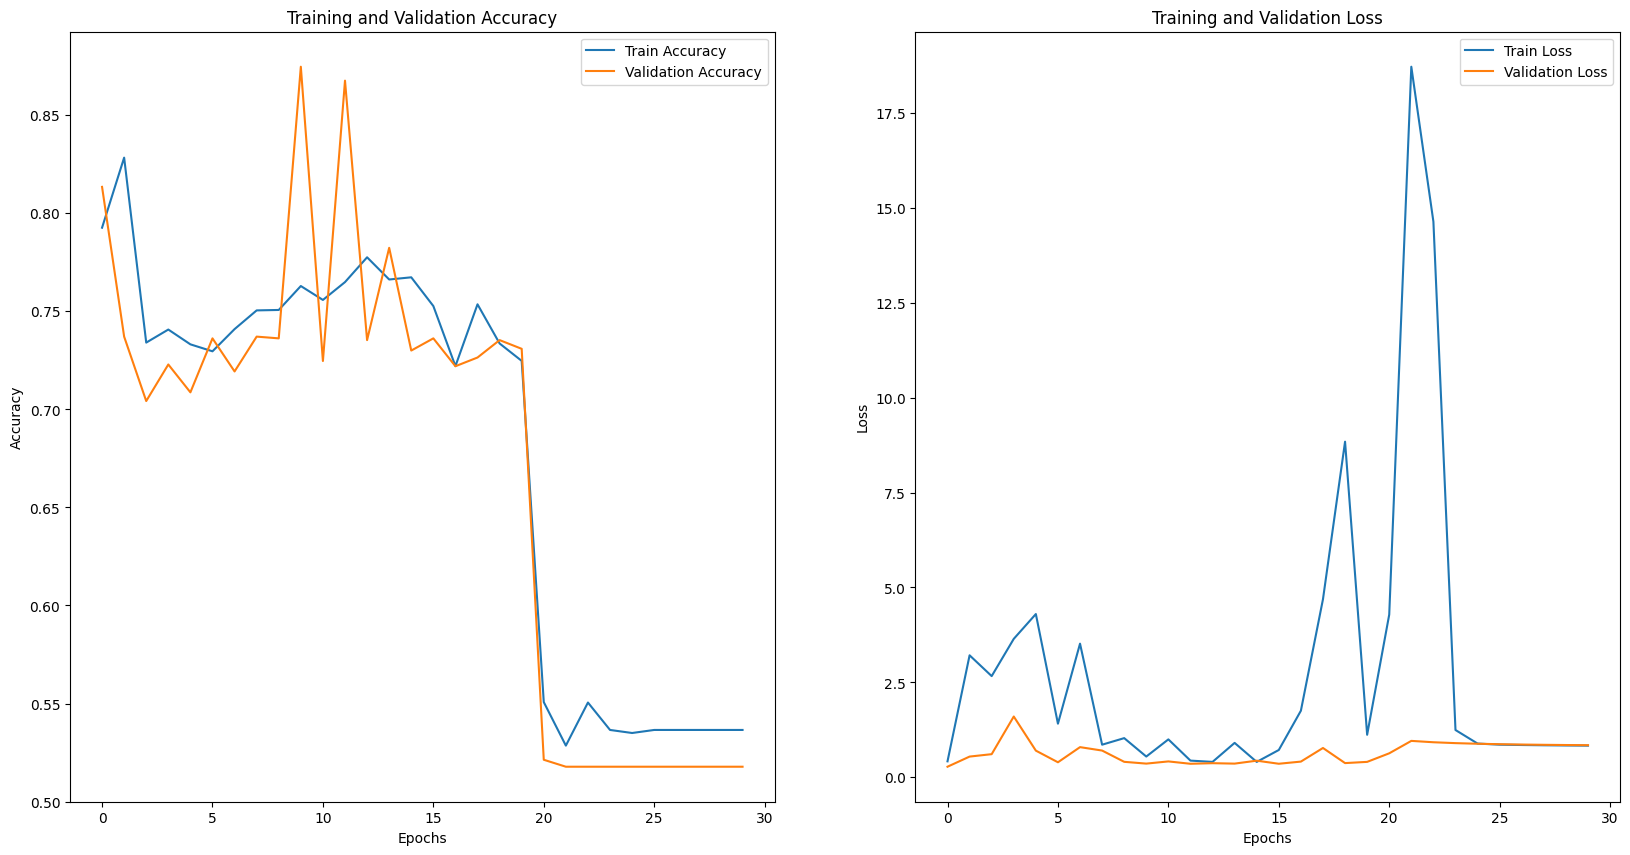

In [10]:
# Visualize the training results
plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

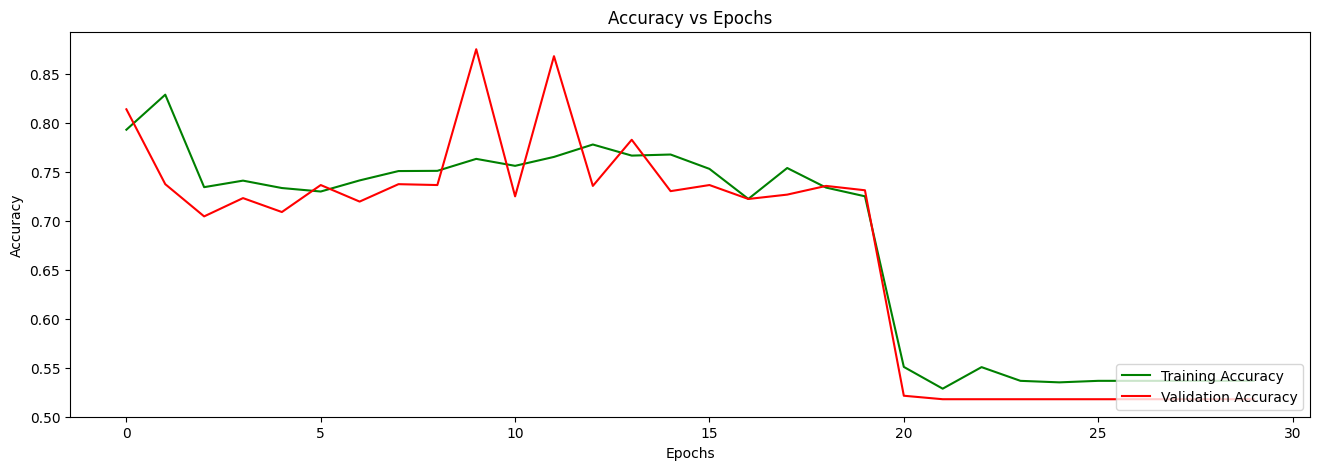

In [11]:
# accuracy and loss

plt.figure(figsize=(16, 5))
plt.plot(range(30), history.history['accuracy'], label='Training Accuracy', color='green')
plt.plot(range(30), history.history['val_accuracy'], label='Validation Accuracy', color='red')
plt.legend(loc='lower right')
plt.title('Accuracy vs Epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.show()

In [12]:
train_set.class_names

['cloudy', 'desert', 'green_area', 'water']

In [13]:
classes = {
    0: 'cloudy',
    1: 'desert',
    2: 'green_area',
    3: 'water'
}

2024-09-19 02:38:16.951911: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 100352: 3.85654, expected 2.92659
2024-09-19 02:38:16.951963: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 100353: 6.2966, expected 5.36665
2024-09-19 02:38:16.951972: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 100354: 5.15789, expected 4.22794
2024-09-19 02:38:16.951981: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 100355: 5.45824, expected 4.52829
2024-09-19 02:38:16.951989: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 100356: 5.63214, expected 4.70219
2024-09-19 02:38:16.951997: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 100357: 5.33488, expected 4.40493
2024-09-19 02:38:16.952005: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 100358: 5.6038, expected 4.67384
2024-09-19 02:38:16.95

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 719ms/step


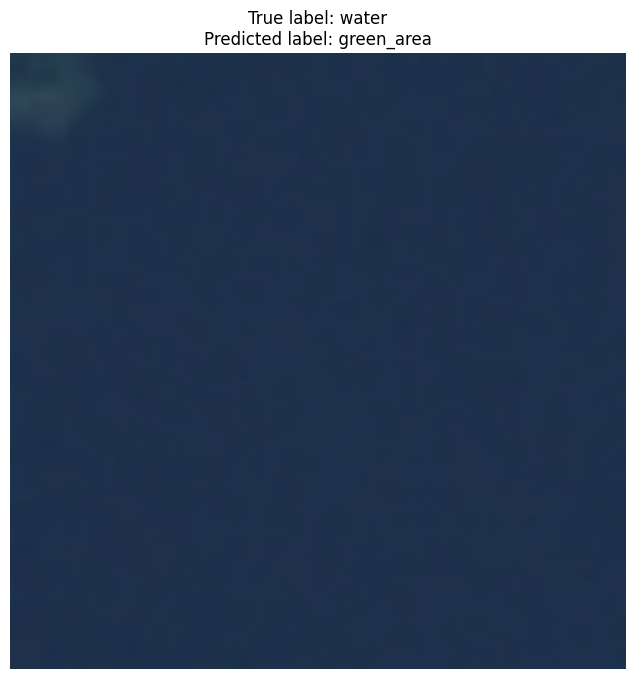

In [14]:
plt.figure(figsize=(12, 8))

for image, label in test_set.take(1):
    sample_img = image[1]
    actual_label = label[1]

    sample_img = tf.expand_dims(sample_img, axis=0)

    predictions = model.predict(sample_img)

    predicted_class_index = tf.argmax(predictions, axis=1).numpy()[0]
    predicted_class = classes[predicted_class_index]

    plt.imshow(sample_img[0].numpy().astype("uint8"))
    plt.title(f"True label: {classes[actual_label.numpy()]}\nPredicted label: {predicted_class}")
    plt.axis('off')
    
plt.show()